In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn
import itertools
import random

In [2]:
# A function that loads data
def get_data(test_fold_id, val_fold_id):
    test_fold = str(test_fold_id)
    val_fold = str(val_fold_id)
    train_fold = [str(i) for i in range(1,6) if i != test_fold_id and i != val_fold_id]
    x_test = np.load("ECG_Signals/Fold_" + test_fold + "/Signals.npy")
    y_test = np.load("ECG_Signals/Fold_" + test_fold + "/Labels.npy")
    x_val = np.load("ECG_Signals/Fold_" + val_fold + "/Signals.npy")
    y_val = np.load("ECG_Signals/Fold_" + val_fold + "/Labels.npy")
    x_train = np.concatenate([np.load("ECG_Signals/Fold_" + i + "/Signals.npy") for i in train_fold], axis=0)
    y_train = np.concatenate([np.load("ECG_Signals/Fold_" + i + "/Labels.npy") for i in train_fold], axis=0)
    return x_train, y_train, x_val, y_val, x_test, y_test

In [3]:
# Oversample the minority class by random sampling with replacement
def oversample(x_train, y_train):
    classes, counts = np.unique(y_train, return_counts=True)
    max_count = np.max(counts)
    for i in range(len(classes)):
        c = classes[i]
        count = counts[i]
        diff = max_count - count
        c_data = x_train[y_train==c]
        upsample_data = sklearn.utils.resample(c_data, replace=True, n_samples=diff, random_state=123)
        x_train = np.concatenate([x_train, upsample_data], axis=0)
        y_train = np.concatenate([y_train, np.full((diff,), c)])

    idx = np.arange(len(y_train))
    np.random.seed(100)
    np.random.shuffle(idx)
    np.random.shuffle(idx)
    x_train = x_train[idx]
    y_train = y_train[idx]
    
    return x_train, y_train

In [4]:
x_train, y_train, x_val, y_val, x_test, y_test = get_data(1, 2)

In [5]:
# COVID vs. Others
y_test[y_test!=1] = 0
y_val[y_val!=1] = 0
y_train[y_train!=1] = 0

In [6]:
# Oversample the training set
x_train, y_train = oversample(x_train, y_train)

In [7]:
# Check if the traning set is balanced
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([915, 915]))

In [8]:
# A function that builds an FCN
def build_FCN(num_classes, input_shape, filters=[64, 128, 64]):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=filters[0], kernel_size=8, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=filters[1], kernel_size=5, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=filters[2], kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [9]:
# Builds an FCN
fcn = build_FCN(2, input_shape=x_train.shape[1:])

In [ ]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "ECG_Models/covid_others/best_models/fcn_121.h5", save_best_only=True, monitor="val_sparse_categorical_accuracy"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_sparse_categorical_accuracy", factor=0.2, patience=5, min_lr=1e-8
    ),
    keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy", patience=20, verbose=1
    ),
    keras.callbacks.CSVLogger("ECG_Models/covid_others/history/fcn_121.csv", separator=",", append=True)
]
fcn.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

history_fcn = fcn.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1,
)

In [10]:
# Load the best FCN model
best_fcn = keras.models.load_model("ECG_Models/covid_others/best_models/fcn_121.h5")
# Evaluate the model on test set
test_loss, test_acc = best_fcn.evaluate(x_test, y_test)

11/11 [==============================] - 0s 9ms/step - loss: 0.0977 - sparse_categorical_accuracy: 0.9858


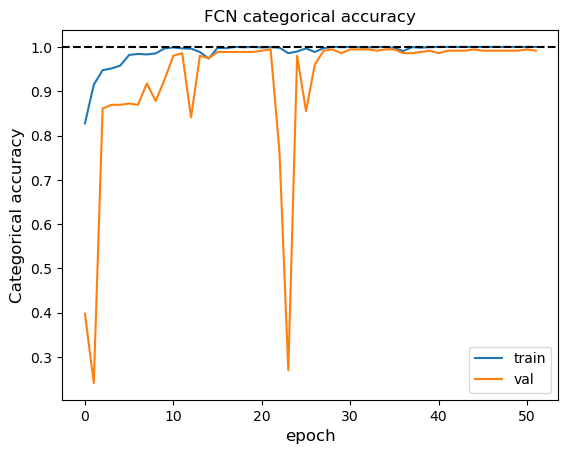

In [11]:
# Plot the sparse categorical accuracy
history = pd.read_csv("ECG_Models/covid_others/history/fcn_121.csv")
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history[metric])
plt.plot(history["val_" + metric])
plt.axhline(y = 1, color = 'black', linestyle = 'dashed')
plt.title("FCN categorical accuracy")
plt.ylabel("Categorical accuracy", fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [12]:
# A function that plots confusion matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

11/11 [==============================] - 0s 6ms/step


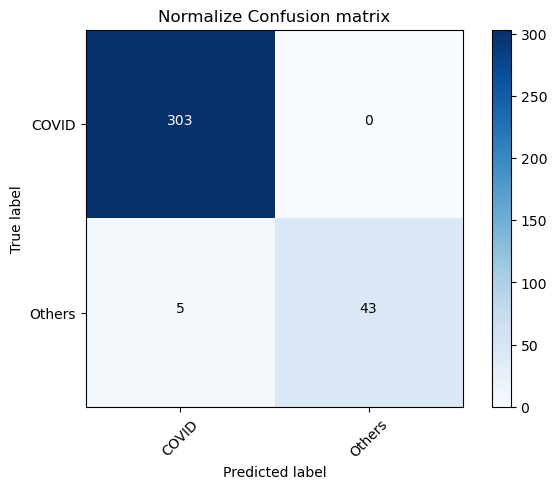

In [13]:
# Class prediction overall
y_pred = tf.argmax(best_fcn.predict(x_test), axis=-1)
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COVID', 'Others'],title='Normalize Confusion matrix')

In [14]:
# A function that builds a residual block
def ResidualBlock(inputs, filters, kernel_sizes):
    conv_x = keras.layers.Conv1D(filters=filters, kernel_size=kernel_sizes[0], padding='same')(inputs)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=filters, kernel_size=kernel_sizes[1], padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=filters, kernel_size=kernel_sizes[2], padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut = keras.layers.Conv1D(filters=filters, kernel_size=1, padding='same')(inputs)
    shortcut = keras.layers.BatchNormalization()(shortcut)

    outputs = keras.layers.Add()([shortcut, conv_z])  # shortcut connection
    outputs = keras.layers.Activation('relu')(outputs)
    return outputs

# A function that builds a ResNet
def build_ResNet(num_classes, input_shape):
    input_layer = keras.layers.Input(input_shape)
    h = keras.layers.BatchNormalization()(input_layer)
    h = ResidualBlock(h, filters=32, kernel_sizes=[8, 5, 3])
    h = ResidualBlock(h, filters=64, kernel_sizes=[8, 5, 3])
    h = ResidualBlock(h, filters=64, kernel_sizes=[8, 5, 3])
    gap = keras.layers.GlobalAveragePooling1D()(h)
    output_layer = keras.layers.Dense(num_classes, activation='softmax')(gap)
    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [15]:
# Build a ResNet model
resnet = build_ResNet(2, input_shape=x_train.shape[1:])

In [ ]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "ECG_Models/test/best_models/resnet_121.h5", save_best_only=True, monitor="val_sparse_categorical_accuracy"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_sparse_categorical_accuracy", factor=0.2, patience=5, min_lr=1e-8
    ),
    keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy", patience=20, verbose=1
    ),
    keras.callbacks.CSVLogger("ECG_Models/covid_normal/history/resnet_121.csv", separator=",", append=True)
]

resnet.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

history_resnet = resnet.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1,
)

In [16]:
best_resnet = keras.models.load_model("ECG_Models/covid_others/best_models/resnet_121.h5")

test_loss, test_acc = best_resnet.evaluate(x_test, y_test)

11/11 [==============================] - 0s 16ms/step - loss: 0.1115 - sparse_categorical_accuracy: 0.9858


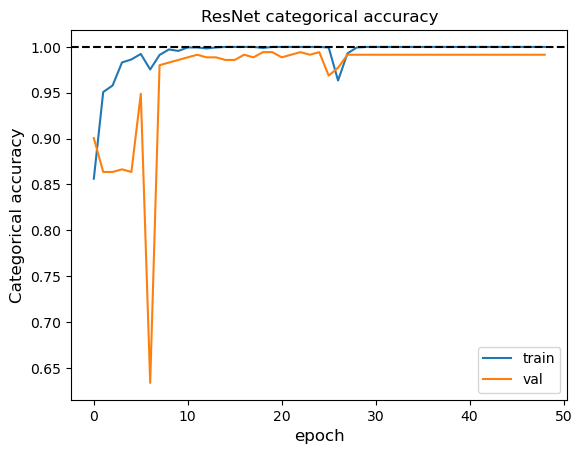

In [17]:
# Plot the sparse categorical accuracy
history = pd.read_csv("ECG_Models/covid_others/history/resnet_121.csv")
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history[metric])
plt.plot(history["val_" + metric])
plt.axhline(y = 1, color = 'black', linestyle = 'dashed')
plt.title("ResNet categorical accuracy")
plt.ylabel("Categorical accuracy", fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

11/11 [==============================] - 0s 15ms/step


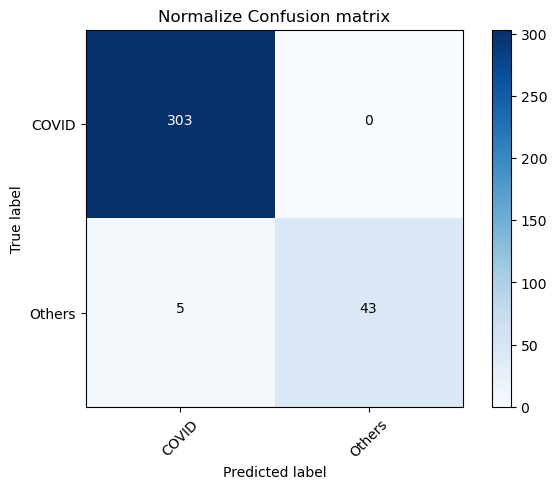

In [18]:
# Class prediction overall
y_pred = tf.argmax(best_resnet.predict(x_test), axis=-1)
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COVID', 'Others'],title='Normalize Confusion matrix')

In [19]:
# A function that builds a ResCNN
def build_ResCNN(num_classes, input_shape):
    input_layer = keras.layers.Input(input_shape)
    h = ResidualBlock(input_layer, filters=64, kernel_sizes=[8, 5, 3])
    h = keras.layers.Conv1D(filters=64, kernel_size=8, padding='same')(h)
    h = keras.layers.BatchNormalization()(h)
    h = tf.keras.layers.LeakyReLU()(h)
    h = keras.layers.Conv1D(filters=128, kernel_size=5, padding='same')(h)
    h = keras.layers.BatchNormalization()(h)
    h = tf.keras.layers.PReLU()(h)
    h = keras.layers.Conv1D(filters=64, kernel_size=8, padding='same')(h)
    h = keras.layers.BatchNormalization()(h)
    h = tf.keras.layers.ELU()(h)
    gap = keras.layers.GlobalAveragePooling1D()(h)
    output_layer = keras.layers.Dense(num_classes, activation='softmax')(gap)
    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [20]:
rescnn = build_ResCNN(2, input_shape=x_train.shape[1:])

In [21]:
# A function that builds an Inception module given input layer, number of filters, list of kernel sizes, bottleneck size
def InceptionModule(inputs, num_filters, kernel_sizes, bottleneck_size):
    if bottleneck_size != None and inputs.shape[-1] > bottleneck_size:
        # bottleneck layer
        reduced = keras.layers.Conv1D(filters=bottleneck_size, kernel_size=1,
                                       padding='same', use_bias=False)(inputs)
    else:
        reduced = inputs
        
    conv_list = []
    for i in range(len(kernel_sizes)):
        conv_list.append(keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_sizes[i],
                                             strides=1, padding='same', use_bias=False)(reduced))
    
    max_pool_0 = keras.layers.MaxPool1D(pool_size=3, strides=1, padding='same')(inputs)
    conv_0 = keras.layers.Conv1D(filters=num_filters, kernel_size=1, padding='same', use_bias=False)(max_pool_0) 
    conv_list.append(conv_0)
    
    h = keras.layers.Concatenate(axis=2)(conv_list)
    h = keras.layers.BatchNormalization()(h)
    h = keras.layers.Activation(activation='relu')(h)
    return h

# A function that builds an Inception block
def InceptionBlock(inputs, num_filters, kernel_sizes, bottleneck_size):
    h = inputs
    for i in range(3):
        h = InceptionModule(h, num_filters, kernel_sizes, bottleneck_size)
    
    shortcut_h = keras.layers.Conv1D(filters=h.shape[-1], kernel_size=1, padding='same', use_bias=False)(inputs)
    shortcut_h = keras.layers.BatchNormalization()(shortcut_h)
    outputs = keras.layers.Add()([shortcut_h, h])
    outputs = keras.layers.Activation('relu')(outputs)

    return outputs

# A function that builds an Inception network
def InceptionNetwork(num_classes, input_shape, num_filters=32, kernel_sizes=[40, 20, 10], bottleneck_size=32):
    input_layer = keras.layers.Input(input_shape)
    h = InceptionBlock(input_layer, num_filters, kernel_sizes, bottleneck_size)
    h = InceptionBlock(h, num_filters, kernel_sizes, bottleneck_size)
    gap_layer = keras.layers.GlobalAveragePooling1D()(h)
    output_layer = keras.layers.Dense(num_classes, activation='softmax')(gap_layer)
    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [22]:
inception = InceptionNetwork(2, x_train.shape[1:])

In [23]:
# Expand input dimension to feed into 2D CNN model
x_train = x_train[...,tf.newaxis]
x_val = x_val[...,tf.newaxis]
x_test = x_test[...,tf.newaxis]

In [24]:
def build_Time2D(num_classes, input_shape):
    input_layer = keras.layers.Input(input_shape, name="Input_Layer")
        
    conv_list = []
    conv1 = keras.layers.Conv2D(filters=64, kernel_size=(40,1), padding="same", name="Module1_Conv1")(input_layer)
    conv_list.append(conv1)
    
    conv2 = keras.layers.Conv2D(filters=64, kernel_size=(20,1), padding="same", name="Module1_Conv2")(input_layer)
    conv_list.append(conv2)
    
    conv3 = keras.layers.Conv2D(filters=64, kernel_size=(10,1), padding="same", name="Module1_Conv3")(input_layer)
    conv_list.append(conv3)
    
    concat = keras.layers.Concatenate(axis=3, name="Module1_Concat")(conv_list)
    h = keras.layers.BatchNormalization(name="Module1_BN")(concat)
    h = keras.layers.Activation(activation='relu', name="Module1_ReLU")(h)
    h = keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same', name="Bottleneck1")(h)
    
    conv_list2 = []
    conv4 = keras.layers.Conv2D(filters=64, kernel_size=(40,1), padding="same", name="Module2_Conv1")(h)
    conv_list2.append(conv4)
    
    conv5 = keras.layers.Conv2D(filters=64, kernel_size=(20,1), padding="same", name="Module2_Conv2")(h)
    conv_list2.append(conv5)
    
    conv6 = keras.layers.Conv2D(filters=64, kernel_size=(10,1), padding="same", name="Module2_Conv3")(h)
    conv_list2.append(conv6)
    
    concat2 = keras.layers.Concatenate(axis=3, name="Module2_Concat")(conv_list2)
    h = keras.layers.BatchNormalization(name="Module2_BN")(concat2)
    h = keras.layers.Activation(activation='relu', name="Module2_ReLU")(h)    
    h = keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same', name="Bottleneck2")(h)
    
    conv_list3 = []
    conv7 = keras.layers.Conv2D(filters=64, kernel_size=(40,1), padding="same", name="Module3_Conv1")(h)
    conv_list3.append(conv7)
    
    conv8 = keras.layers.Conv2D(filters=64, kernel_size=(20,1), padding="same", name="Module3_Conv2")(h)
    conv_list3.append(conv8)
    
    conv9 = keras.layers.Conv2D(filters=64, kernel_size=(10,1), padding="same", name="Module3_Conv3")(h)
    conv_list3.append(conv9)
    
    concat3 = keras.layers.Concatenate(axis=3, name="Module3_Concat")(conv_list3)
    h = keras.layers.BatchNormalization(name="Module3_BN")(concat3)
    h = keras.layers.Activation(activation='relu', name="Module3_ReLU")(h)
    
    pooling = keras.layers.AveragePooling2D((400, 1), name="AvgPool")(h)
    flatten = keras.layers.Flatten(name="Flatten")(pooling)
    output_layer = keras.layers.Dense(num_classes, activation="softmax", name="Prediction")(flatten)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [25]:
time2D = build_Time2D(2, x_train.shape[1:])

In [26]:
# Load and prepare test data
def get_test_data(test_fold, problem):
    x_test = np.load("ECG_Signals/Fold_" + str(test_fold) + "/Signals.npy")
    y_test = np.load("ECG_Signals/Fold_" + str(test_fold) + "/Labels.npy")
    if problem == "3_classes":
        y_test[y_test>1] = 2
    elif problem == "covid_others":
        y_test[y_test!=1] = 0
    elif problem == "covid_normal":
        x_test = x_test[y_test<=1]
        y_test = y_test[y_test<=1]
    return x_test, y_test

In [27]:
# Ensemble 5 networks
def Ensemble_prediction(model, problem, x, folds):
    prediction = 0
    for i in range(1, 6):
        best_model = keras.models.load_model("ECG_Models/"+problem+"/best_models/"+model+"_"+str(folds)+str(i)+".h5")
        prediction += best_model.predict(x)
    prediction /= 5
    return prediction

problem = "covid_others"
model = "resnet"

acc = np.zeros((5,))  # Accuracy
auc = np.zeros((5,))  # AUC
sens = np.zeros((5,))  # Sensitivity
spec = np.zeros((5,))  # Specificity
f1score = np.zeros((5,))  # F1-Score

# Calculate average performance metrics
for i, j in [(1,2), (2,3), (3,4), (4,5), (5,1)]:
    print(i, j)
    x_test, y_test = get_test_data(i, problem)
    pred_prob = Ensemble_prediction(model, problem, x_test, str(i)+str(j))
    pred = np.argmax(pred_prob, axis=1)
    m =  sklearn.metrics.confusion_matrix(y_test, pred)
    acc[i-1] = sklearn.metrics.accuracy_score(y_test, pred)
    sens[i-1] = m[0,0] / (m[0,0] + m[1,0])
    spec[i-1] = m[1,1] / (m[1,1] + m[0,1])
    prec = m[0,0] / (m[0,0] + m[0,1])
    auc[i-1] = sklearn.metrics.roc_auc_score(y_test,pred_prob[:,1])
    f1score[i-1] = 2*(prec)*sens[i-1]/(prec+sens[i-1])

1 2
11/11 [==============================] - 1s 22ms/step
2 3
11/11 [==============================] - 0s 9ms/step
3 4
12/12 [==============================] - 1s 18ms/step
4 5
12/12 [==============================] - 1s 23ms/step
5 1
12/12 [==============================] - 1s 19ms/step


In [28]:
print('acc:',np.mean(acc)*100)
print('sens:',np.mean(sens)*100)
print('spec:',np.mean(spec)*100)
print('f1-score:',np.mean(f1score)*100)
print('auc:',np.mean(auc)*100)

acc: 98.81001913910656
sens: 98.89354491204276
spec: 98.33260963960052
f1-score: 99.31291585186858
auc: 97.83185071439497


In [29]:
# Compute average standard deviation of accuracy
problem = "covid_others"
model = "resnet"
std_acc = np.zeros((5,))
for i, j in [(1,2), (2,3), (3,4), (4,5), (5,1)]:
    print(i, j)
    x_test, y_test = get_test_data(i, problem)
    acc = np.zeros((5,))
    for k in range(1, 6):
        best_model = keras.models.load_model("ECG_Models/"+problem+"/best_models/"+model+"_"+str(i)+str(j)+str(k)+".h5")
        pred = best_model.predict(x_test)
        pred = np.argmax(pred, axis=1)
        acc[k-1] = sklearn.metrics.accuracy_score(y_test, pred)
    print(acc)
    std_acc[i-1] = np.std(acc)
print("Average std accuracy", np.mean(std_acc))

1 2
11/11 [==============================] - 1s 26ms/step
[0.99 0.99 0.99 0.98 0.98]
2 3
11/11 [==============================] - 1s 9ms/step
[0.99 0.99 0.98 0.98 0.99]
3 4
12/12 [==============================] - 1s 18ms/step
[0.99 0.99 0.99 0.98 0.99]
4 5
12/12 [==============================] - 1s 23ms/step
[0.98 0.98 0.97 0.98 0.98]
5 1
12/12 [==============================] - 1s 28ms/step
[1.   0.97 0.99 0.98 0.99]
Average std accuracy 0.005610458805473817
